### Covid 19 Detection using X-rays

__Importing required packages__

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import cv2
import glob

import warnings
warnings.filterwarnings('ignore')

### 1. Data Preparation

In [14]:
#Checking the current directory
os.getcwd()

'D:\\Computer Vision Projects\\Covid Detection from Xrays'

__We will use two sources for getting the data:__
    
- [Open database of COVID-19 cases with chest X-ray or CT images](https://github.com/ieee8023/covid-chestxray-dataset)
- [Kaggle Pneumonia dataset](https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset)

__Covid19 Positive__

__Note: Using the first source: Open database of COVID-19 cases with chest X-ray or CT images, we will collect all positive covid images__

__Create a folder named Final Dataset and inside that create two sub 
folders namely Covid19 Positive, Covid19 Negative. Then run below code__

In [15]:
data_path1 = 'Covid Chest Xray Dataset'
final_dataset_path = 'Final Dataset'

categories = os.listdir(final_dataset_path)
print(categories)

['Covid19 Negative', 'Covid19 Positive']


__Now we will prepare image datasets for Positive cases and upload all images to the Covid19 Positive folder__

In [16]:
#Loading the metadata file
open_dataset = pd.read_csv(os.path.join(data_path1, 'metadata.csv'))
open_dataset.head()

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [17]:
open_dataset.columns

Index(['patientid', 'offset', 'sex', 'age', 'finding', 'RT_PCR_positive',
       'survival', 'intubated', 'intubation_present', 'went_icu', 'in_icu',
       'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation',
       'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view',
       'modality', 'date', 'location', 'folder', 'filename', 'doi', 'url',
       'license', 'clinical_notes', 'other_notes', 'Unnamed: 29'],
      dtype='object')

__Now we need to filter out all Covid19 records under finding column and their respective images under filename column__

In [18]:
covid_sars = open_dataset['finding']
images = open_dataset['filename']

In [19]:
covid_sars.unique()

array(['Pneumonia/Viral/COVID-19', 'Pneumonia', 'Pneumonia/Viral/SARS',
       'Pneumonia/Fungal/Pneumocystis',
       'Pneumonia/Bacterial/Streptococcus', 'No Finding',
       'Pneumonia/Bacterial/Chlamydophila', 'Pneumonia/Bacterial/E.Coli',
       'Pneumonia/Bacterial/Klebsiella', 'Pneumonia/Bacterial/Legionella',
       'Unknown', 'Pneumonia/Lipoid', 'Pneumonia/Viral/Varicella',
       'Pneumonia/Bacterial', 'Pneumonia/Bacterial/Mycoplasma',
       'Pneumonia/Viral/Influenza', 'todo', 'Tuberculosis',
       'Pneumonia/Viral/Influenza/H1N1', 'Pneumonia/Fungal/Aspergillosis',
       'Pneumonia/Viral/Herpes ', 'Pneumonia/Aspiration',
       'Pneumonia/Bacterial/Nocardia', 'Pneumonia/Viral/MERS-CoV',
       'Pneumonia/Bacterial/Staphylococcus/MRSA'], dtype=object)

__We will consider Covid 19 and SARS together since both have similar effects__

In [20]:
positive_cases = np.concatenate((np.where(covid_sars == 'Pneumonia/Viral/COVID-19')[0], (np.where(covid_sars == 'Pneumonia/Viral/SARS')[0])))
positive_images = images[positive_cases]
len(positive_images)

600

__We go to the path 'Covid Chest Xray Dataset\images' and read all positive images which we want and write it to the path 'Final Dataset\Covid19 Positive'__

In [80]:
for i in positive_images:
    image = cv2.imread(os.path.join(data_path1, 'images', i))
    try:
        cv2.imwrite(os.path.join(final_dataset_path, categories[1], i), image)
    except Exception as error_message: 
        print(error_message)

OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\imgcodecs\src\loadsave.cpp:662: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'

OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\imgcodecs\src\loadsave.cpp:662: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'

OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\imgcodecs\src\loadsave.cpp:662: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'

OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\imgcodecs\src\loadsave.cpp:662: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'

OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\imgcodecs\src\loadsave.cpp:662: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::i

__Using the second source: Kaggle Pneumonia dataset, we will collect both covid positive and negative images__

__First lets collect Covid19 positive images__

In [21]:
data_path2='Kaggle Pneumonia Dataset'
kaggle_dataset = pd.read_csv(os.path.join(data_path2,'Metadata.csv'))
kaggle_dataset.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [22]:
kaggle_dataset.columns

Index(['Unnamed: 0', 'X_ray_image_name', 'Label', 'Dataset_type',
       'Label_2_Virus_category', 'Label_1_Virus_category'],
      dtype='object')

__Now we will select COVID-19 and SARS as positive cases under Label_2_Virus_category column and get the images and upload those images to the Covid19 Positive folder which we have already created__

In [23]:
covid_sars = kaggle_dataset['Label_2_Virus_category']
images = kaggle_dataset['X_ray_image_name']

In [24]:
covid_sars.unique()

array([nan, 'Streptococcus', 'COVID-19', 'ARDS', 'SARS'], dtype=object)

In [25]:
positive_cases = np.concatenate((np.where(covid_sars == 'COVID-19')[0], (np.where(covid_sars == 'SARS')[0])))
positive_images = images[positive_cases]

In [26]:
len(positive_images)

62

__Read and write all positive images to the Covid19 Positive Folder__

In [87]:
for i in positive_images:
    image = cv2.imread(os.path.join(data_path2, 'images', i))
    try:
        cv2.imwrite(os.path.join(final_dataset_path, categories[1], i), image)
    except Exception as error_message: 
        print(error_message)

__Covid19 Negative__

__Now we will prepare image datasets for Negative cases and upload all images to the Covid19 Negative folder__

In [27]:
kaggle_dataset.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [28]:
label_col = kaggle_dataset['Label']
images = kaggle_dataset['X_ray_image_name']
label_col.unique()

array(['Normal', 'Pnemonia'], dtype=object)

__We will consider 'Normal' as Covid19 Negative cases__

In [29]:
negative_cases = np.where(label_col == 'Normal')[0]
negative_images = images[negative_cases]

In [30]:
len(negative_images)

1576

__Read and write all normal images to the Covid19 Negative Folder__

In [92]:
for i in negative_images:
    image = cv2.imread(os.path.join(data_path2, 'images', i))
    try:
        cv2.imwrite(os.path.join(final_dataset_path, categories[0], i), image)
    except Exception as error_message: 
        print(error_message)

### 2. Data Processing

In [31]:
#Reading the data folders
data_dir = 'D:\Computer Vision Projects\Covid Detection from Xrays\Final Dataset'
os.listdir(data_dir)

['Covid19 Negative', 'Covid19 Positive']

__Image Histograms__

An image histogram is a type of histogram that acts as a graphical representation of the tonal distribution in a digital image. It plots the number of pixels for each tonal value. By looking at the histogram for a specific image a viewer will be able to judge the entire tonal distribution at a glance.

Source: https://en.wikipedia.org/wiki/Image_histogram

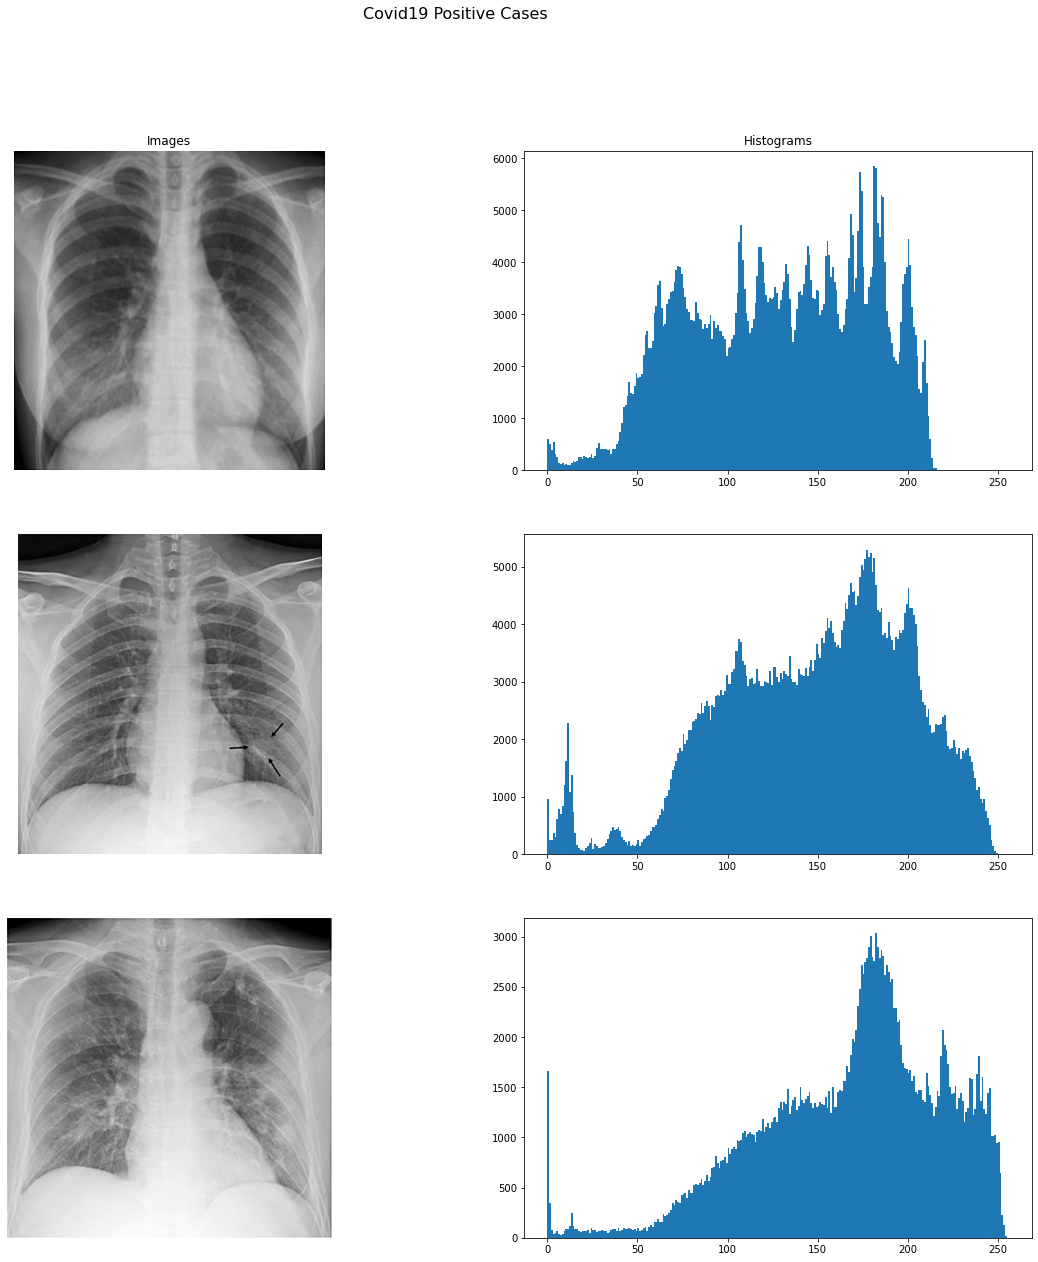

In [32]:
# Plot b/w image histograms of Label_2_Virus_category type "COVID-19" patients 
fig, ax = plt.subplots(3, 2, figsize=(20, 20))

covid19_type_file_paths = kaggle_dataset[kaggle_dataset['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'].values
sample_covid19_file_paths = covid19_type_file_paths[:3]
sample_covid19_file_paths = list(map(lambda x: os.path.join(data_dir + '\Covid19 Positive', x), sample_covid19_file_paths))

for row, file_path in enumerate(sample_covid19_file_paths):
    image = plt.imread(file_path)
    ax[row, 0].imshow(image)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Covid19 Positive Cases', size=16)
plt.show()

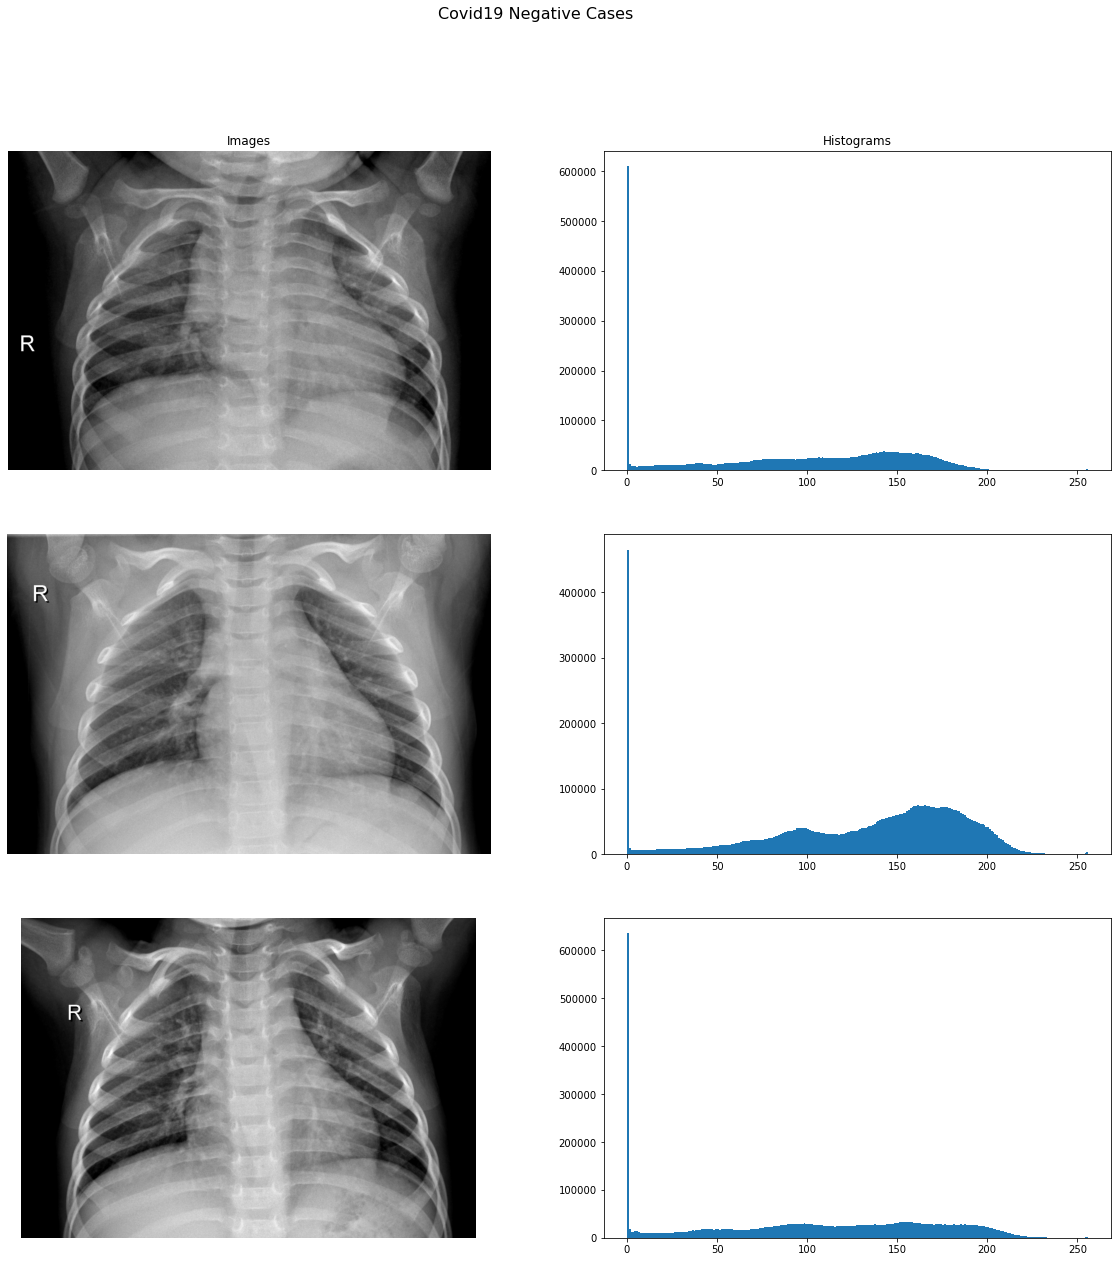

In [33]:
# Plot b/w image histograms of Label type "Covid Negative" patients 
fig, ax = plt.subplots(3, 2, figsize=(20, 20))

other_type_file_paths = kaggle_dataset[kaggle_dataset['Label'] == 'Normal']['X_ray_image_name'].values
sample_other_file_paths = other_type_file_paths[:3]
sample_other_file_paths = list(map(lambda x: os.path.join(data_dir + '\Covid19 Negative', x), sample_other_file_paths))

for row, file_path in enumerate(sample_other_file_paths):
    image = plt.imread(file_path)
    ax[row, 0].imshow(image)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Covid19 Negative Cases', size=16)
plt.show()

__Observation__

- From the sample images, seperated according to Covid Positive and Negative, we can infer the difference in image histograms.
- The sample histograms of images having Covid Positive are mostly left skewed histograms.
- The sample histograms of images having Covid Negative are mostly right skewed histograms.

__Now we will split the dataset into training and testing sets using splitfolders package__

In [34]:
#!pip install split-folders
import splitfolders

In [2]:
splitfolders.ratio(r'D:\Computer Vision Projects\Covid Detection from Xrays\Final Dataset', 
                   output=r'D:\Computer Vision Projects\Covid Detection from Xrays\Output', 
                   seed=42, ratio=(0.8, 0.2)) 

__Define the constants__

In [35]:
train_path = r'D:\Computer Vision Projects\Covid Detection from Xrays\Output\train'
test_path = r'D:\Computer Vision Projects\Covid Detection from Xrays\Output\test'

In [40]:
covid_negative_train_images = glob.glob(train_path+"/Covid19 Negative/*")
covid_positive_train_images = glob.glob(train_path+"/Covid19 Positive/*")

__Lets visualize the data__

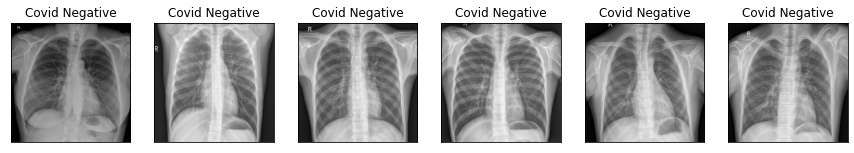

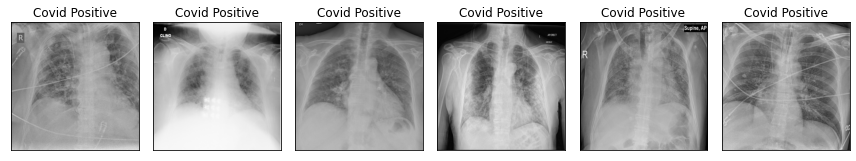

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(covid_negative_train_images[i])
    img = cv2.resize(img, (500,500))
    ax.imshow(img)
    ax.set_title("Covid Negative")
    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(12,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(covid_positive_train_images[i])
    img = cv2.resize(img, (500,500))
    ax.imshow(img)
    ax.set_title("Covid Positive")
fig.tight_layout()    
plt.show()

__Canny edge detection__

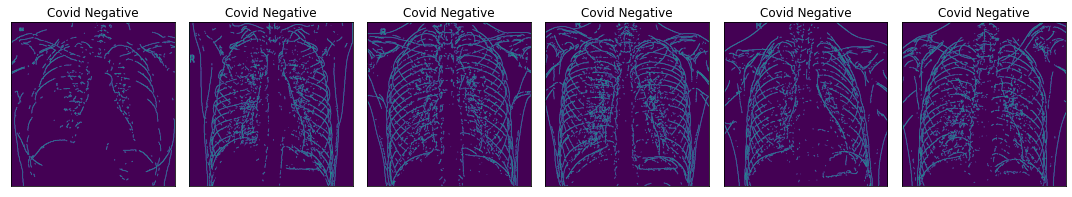

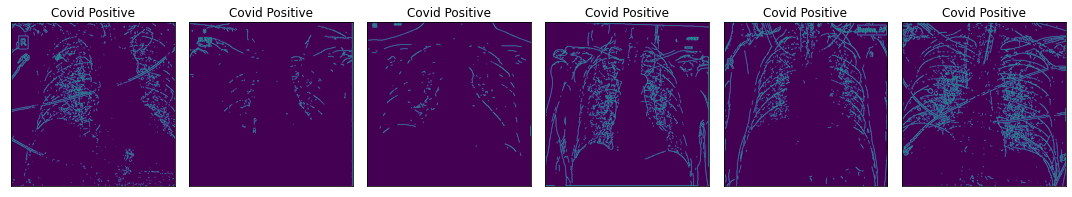

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(covid_negative_train_images[i])
    img = cv2.resize(img, (512,512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.Canny(img, 80, 100)
    ax.imshow(img)
    ax.set_title("Covid Negative")
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(covid_positive_train_images[i])
    img = cv2.resize(img, (512,512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.Canny(img, 80, 100)
    ax.imshow(img)
    ax.set_title("Covid Positive")
fig.tight_layout()    
plt.show()

__We can see that it is difficult to detect edges in the x-rays with covid positive whereas the covid negative images are clear with prominent edges__

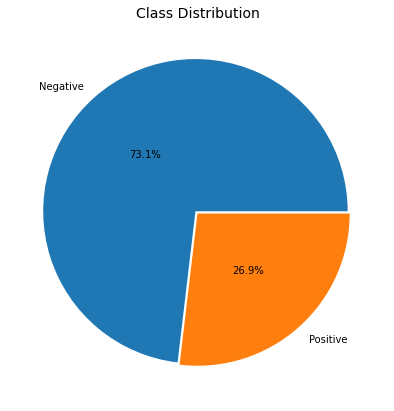

In [47]:
plt.figure(figsize=(12, 7))
plt.pie(x=np.array([len(covid_negative_train_images), len(covid_positive_train_images)]), autopct="%.1f%%", explode=[0.02,0], labels=["Negative", "Positive"], pctdistance=0.5)
plt.title("Class Distribution", fontsize=14);

__We see that we have an imbalanced dataset. Hence, we will be using image augmentation techniques to compensate for this.__